In [76]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromDict

{'NC_000067.7': 'chr1',
 'NC_000068.8': 'chr2',
 'NC_000069.7': 'chr3',
 'NC_000070.7': 'chr4',
 'NC_000071.7': 'chr5',
 'NC_000072.7': 'chr6',
 'NC_000073.7': 'chr7',
 'NC_000074.7': 'chr8',
 'NC_000075.7': 'chr9',
 'NC_000076.7': 'chr10',
 'NC_000077.7': 'chr11',
 'NC_000078.7': 'chr12',
 'NC_000079.7': 'chr13',
 'NC_000080.7': 'chr14',
 'NC_000081.7': 'chr15',
 'NC_000082.7': 'chr16',
 'NC_000083.7': 'chr17',
 'NC_000084.7': 'chr18',
 'NC_000085.7': 'chr19',
 'NC_000086.8': 'chrX',
 'NC_000087.8': 'chrY'}

In [3]:
chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [4]:
reload(pcu)

# load pore c data 
scPorecFilepath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/matrix/"

cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

porec = {}

for cell in filetags:
    fullPath = f"{scPorecFilepath}NlaIII_{cell}_GRCm39_unphased.matrix.mcool"
    
    A, porecChromInfo, porecIndex = pcu.loadPorecCooler(fullPath, assembly, chromOrder)    
    
    # reindex
    porecMat = A[porecIndex, :][:, porecIndex]
    
    print(f"{cell=} {porecMat.shape=}")
    
    porec[cell] = porecMat
    
porec.keys()

cell='run01' porecMat.shape=(2734, 2734)
cell='run02' porecMat.shape=(2734, 2734)
cell='run04' porecMat.shape=(2734, 2734)
cell='run05' porecMat.shape=(2734, 2734)
cell='run06' porecMat.shape=(2734, 2734)
cell='run07' porecMat.shape=(2734, 2734)


dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])

In [5]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


In [6]:
sampleSize = len(porec) # sample 6 randomly
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for s in sample:
    filetag = "_".join(s.split("_")[0:2]).replace("/", "")    
    A, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    # reindex the matrix
    hicMat = A[hicIndex, :][:, hicIndex]
    print(f"{filetag=} {hicMat.shape=}")
    
    hic[filetag] = hicMat

hic.keys()

filetag='Diploid_35' hicMat.shape=(2665, 2665)
filetag='Diploid_31' hicMat.shape=(2665, 2665)
filetag='Diploid_4' hicMat.shape=(2665, 2665)
filetag='Diploid_8' hicMat.shape=(2665, 2665)
filetag='Diploid_25' hicMat.shape=(2665, 2665)
filetag='Diploid_3' hicMat.shape=(2665, 2665)


dict_keys(['Diploid_35', 'Diploid_31', 'Diploid_4', 'Diploid_8', 'Diploid_25', 'Diploid_3'])

In [7]:
# break

SyntaxError: 'break' outside loop (<ipython-input-7-6aaf1f276005>, line 1)

In [14]:
hicChromInfo.head()

,region,start,end,length
0,chr10,0,130,130
1,chr11,130,252,122
2,chr12,252,374,122
3,chr13,374,495,121
4,chr13_random,495,496,1


pore-c
sumContacts=690041
sumDiag=2603
sumUpper=687438
diagUpperRatio=0.004

hi-c
sumContacts=93397
sumDiag=2573
sumUpper=90824
diagUpperRatio=0.028


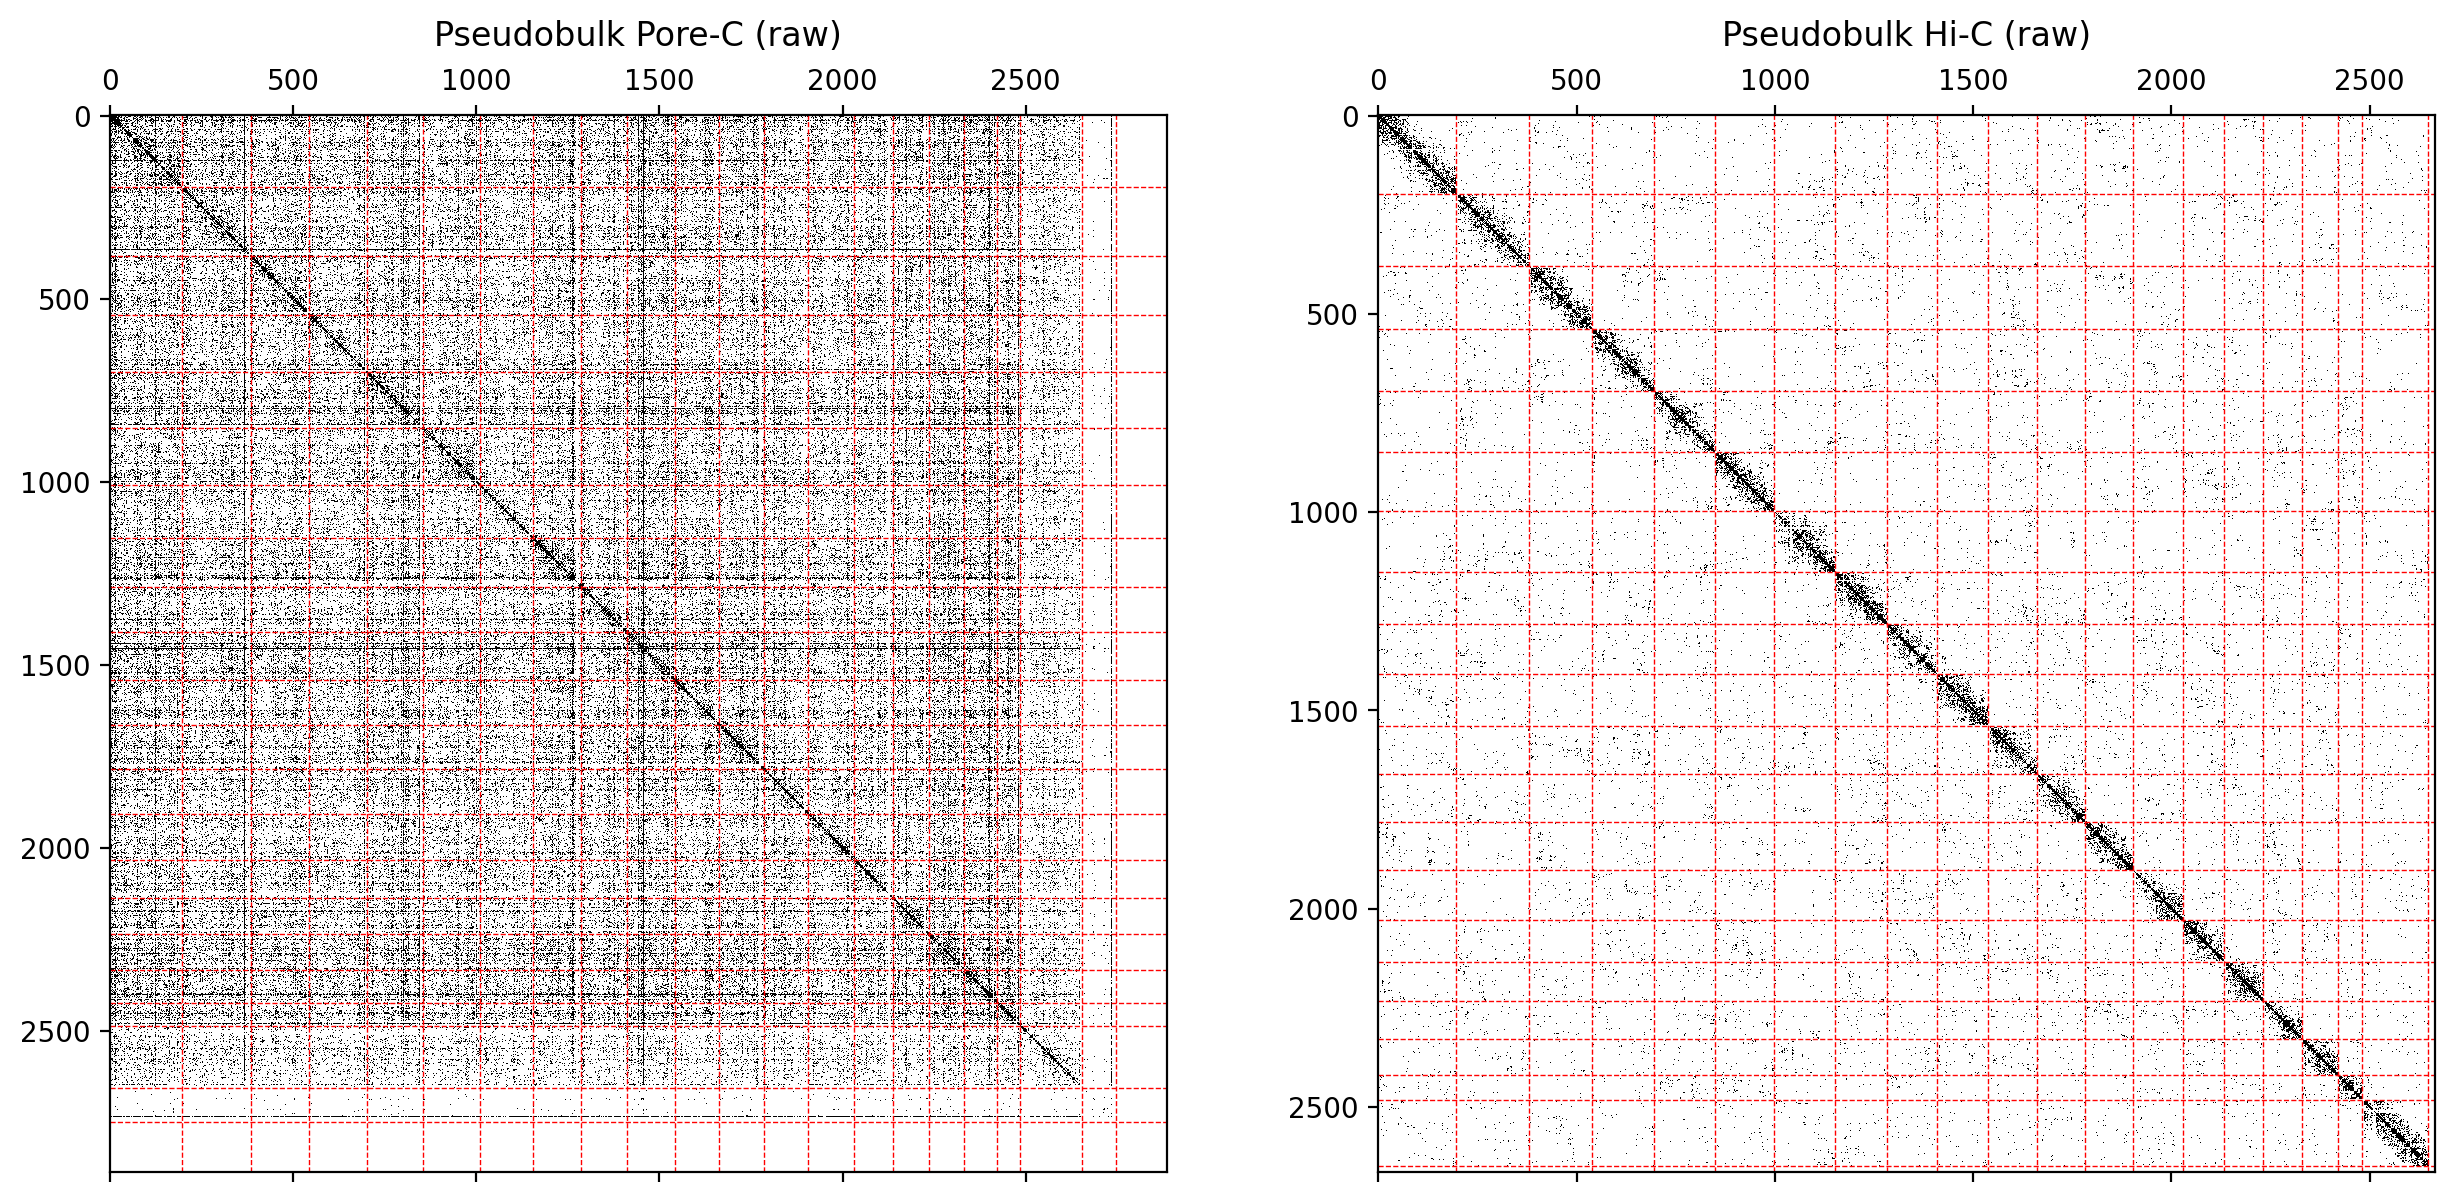

In [44]:
# pseduobulk summaries

def getStats(A):
    sumContacts = np.triu(A).sum()
    sumDiag = np.diag(A).sum()
    sumUpper = np.triu(A).sum() - sumDiag
    diagUpperRatio = sumDiag / sumUpper
    
    print(f"{sumContacts=}")
    print(f"{sumDiag=}")
    print(f"{sumUpper=}")
    print(f"{diagUpperRatio=:.3f}")

bulkPoreC = np.zeros(porecMat.shape)
for runId, A in porec.items():
    bulkPoreC += A
    
bulkP = np.where(bulkPoreC > 0 , 1, 0)    
print("pore-c")
getStats(bulkP)
    
bulkhiC = np.zeros(hicMat.shape)
for runId, A in hic.items():
    bulkhiC += A
    
bulkH = np.where(bulkhiC > 0 , 1, 0) 
print("\nhi-c")
getStats(bulkH)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(bulkP, cmap='binary')
ax1.set_title('Pseudobulk Pore-C (raw)')
for idx, row in porecChromInfo.iterrows():
    ax1.axhline(y=row['end'], lw=0.5, ls='--', c='r')
    ax1.axvline(x=row['end'], lw=0.5, ls='--', c='r')


ax2.matshow(bulkH, cmap='binary')
ax2.set_title('Pseudobulk Hi-C (raw)')

for idx, row in hicChromInfo.iterrows():
    if not 'random' in row['region'] and 'M' not in row['region']:
        
        # remap to shuffled chrom positions
        pos = hicIndex.index(row['end'] - 1)

        ax2.axhline(y=pos, lw=0.5, ls='--', c='r')
        ax2.axvline(x=pos, lw=0.5, ls='--', c='r')

hicChr.shape=(91, 91)
porecChr.shape=(91, 91)


Text(0.5, 1.05, 'Pseudobulk Hi-C (raw, chr18)')

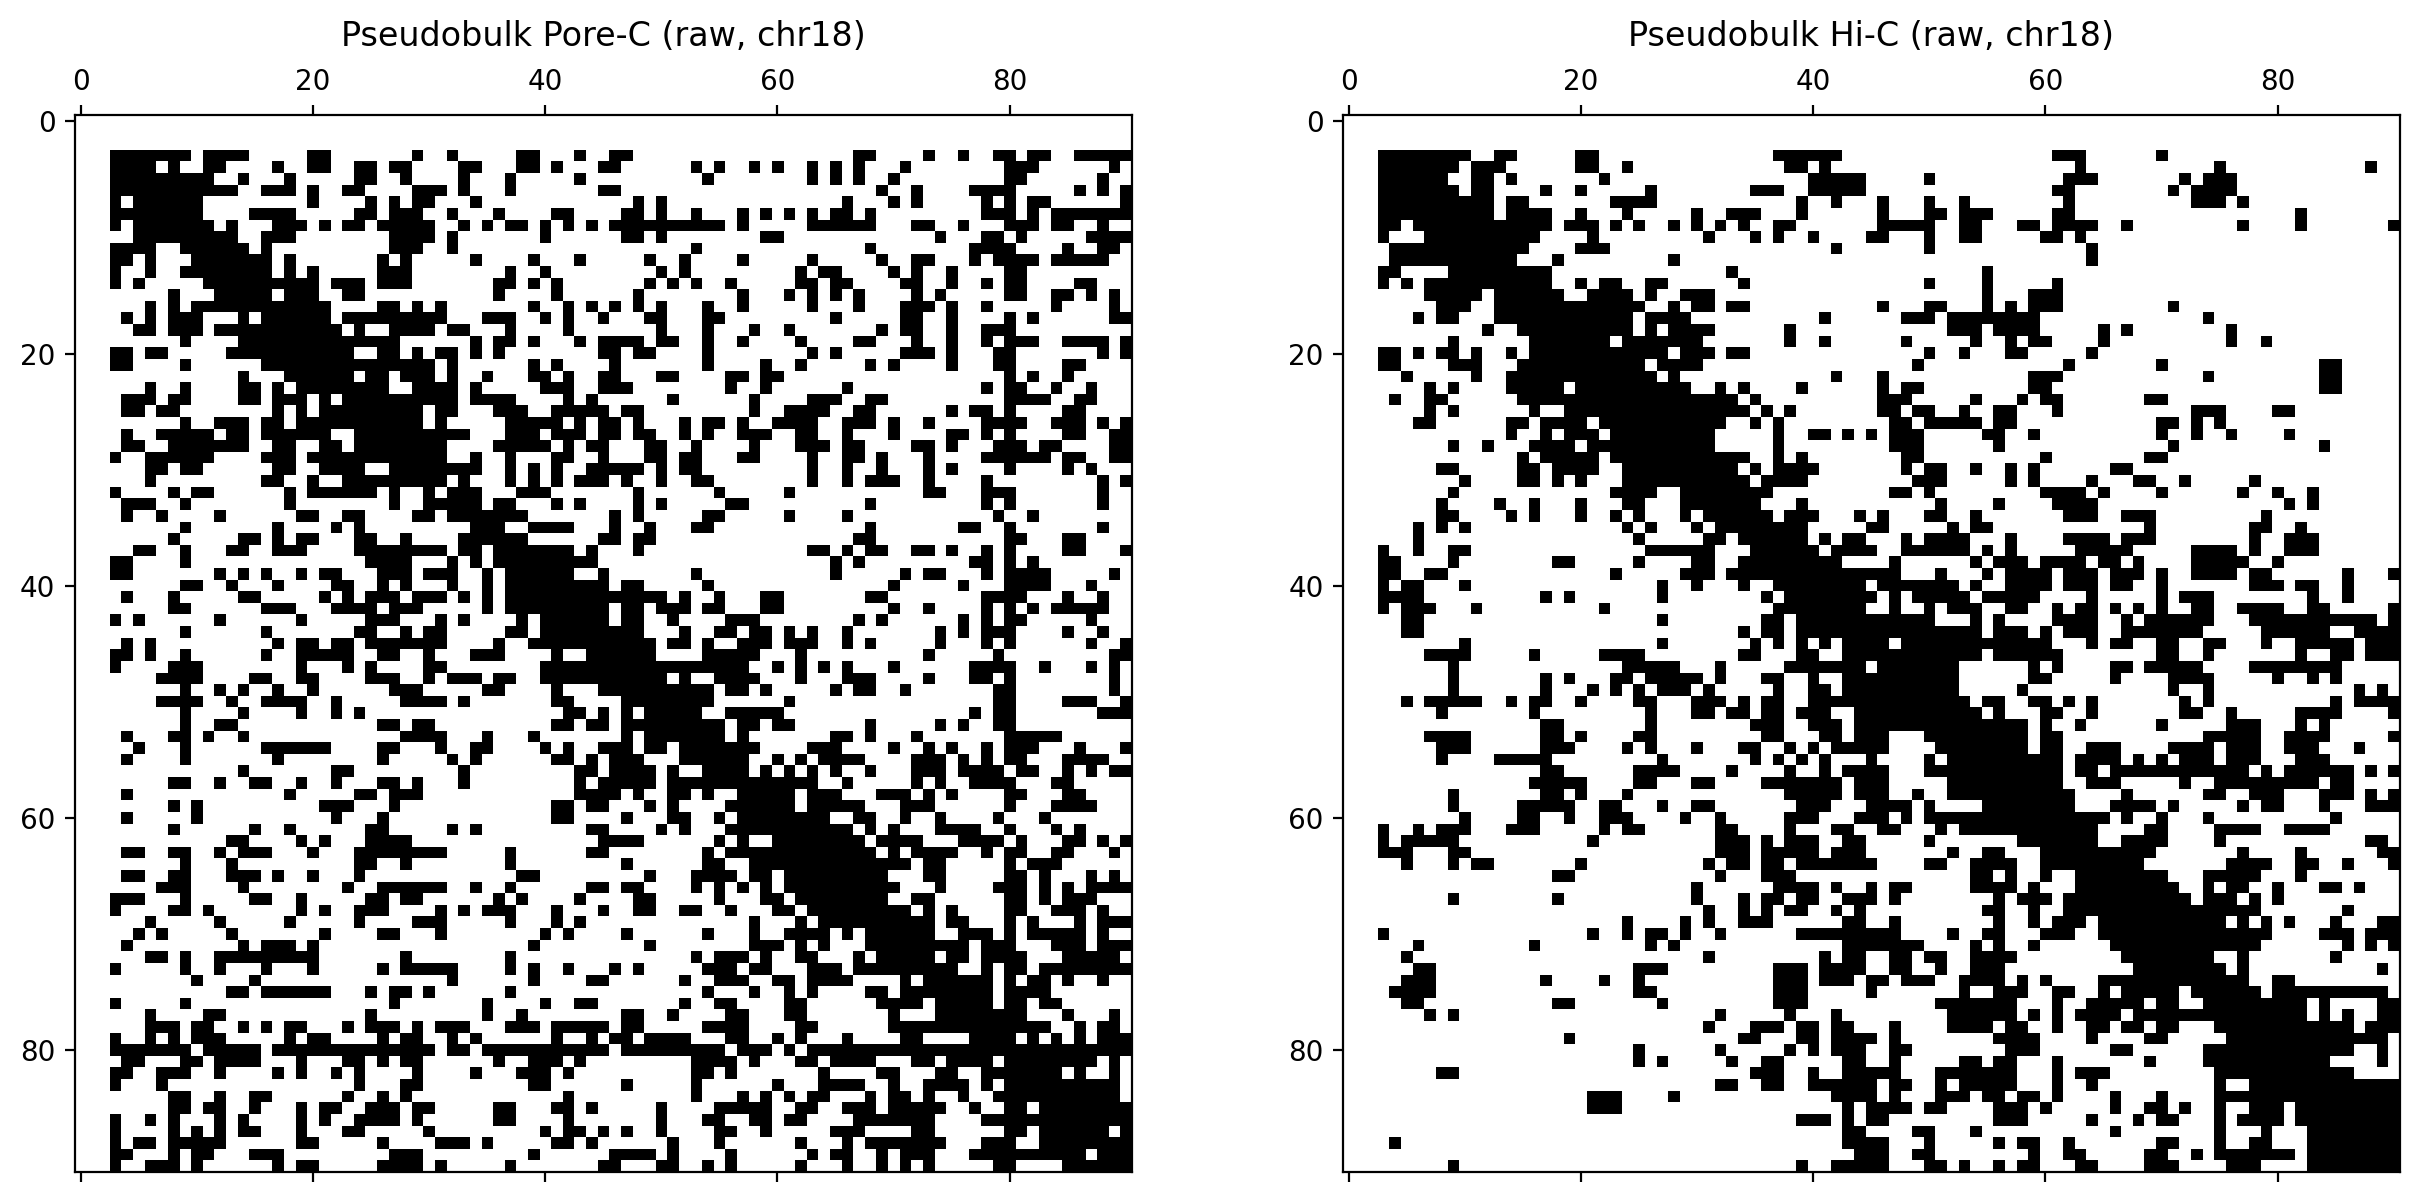

In [74]:
# pseduobulk oberserved over expected

def getIndices(chromInfo, reIndexed, chromosome, lookUpColumn):
    """A function to get indices """
    row = chromInfo.loc[chromInfo[lookUpColumn] == chromosome]
    
    start = row['start'].values[0]
    end = row['end'].values[0]
    chromLength = end - start
    
    newIndexStart = reIndexed.index(start)
    subsetIndex = list(range(newIndexStart, newIndexStart+chromLength))
    return subsetIndex
    

chromosome = 'chr18'
chrHicInd = getIndices(hicChromInfo, hicIndex, chromosome, 'region')
chrPorecInd = getIndices(porecChromInfo, porecIndex, chromosome, 'chromName')

hicChr = bulkH[chrHicInd, :][:, chrHicInd]
porecChr = bulkP[chrPorecInd, :][:, chrPorecInd]

print(f"{hicChr.shape=}")
print(f"{porecChr.shape=}")


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(porecChr, cmap='binary')
ax1.set_title(f'Pseudobulk Pore-C (raw, {chromosome})')

ax2.matshow(hicChr, cmap='binary')
ax2.set_title(f'Pseudobulk Hi-C (raw, {chromosome})')

In [ ]:
# break

In [ ]:
# load the filtered pore-C data
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

# filetags = [f"run0{x}" for x in range(1, 2)]

assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
rawCells = pcu.loadRawContactDirectory(dirpath, filetags)


filteredCells = filters.runAllFilters(rawCells,
                              assembly,
                              adjacent=False,
                              chromosome=None, 
                              verbose=False)  

print(f"{filteredCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
------------------------------
runId='run01'
cf.shape=(146231, 64)
-- -- --
Total Reads 43664 (1.000)
Singletons 19218 (0.440)
Pairs 8120 (0.186)
Multiway 16326 (0.374)
-- -- --
Total Contacts 146231 (1.000)
cis Contacts 133926 (0.916)
trans Contacts 12305 (0.084)
-- -- --
Total Contacts 146231 (1.000)
Direct Contacts 52876 (0.362)
Indirect Contacts 93355 (0.638)

------------------------------
runId='run02'
cf.shape=(72884, 64)
-- -- --
Total Reads 22279 (1.000)
Singletons 9847 (0.442)
Pairs 4282 (0.192)
Multiway 8150 (0.366)
-- -- --
Total Contacts 72884 (1.000)
cis Contacts 65612 (0.900)
trans Contacts 7272 (0.100)
-- -- --
Total Contacts 72884 (1.000)
Direct Contacts 26077 (0.358)
Indirect Contacts 46807 (0.642)



In [ ]:
# zippedKeys = list(zip(porec.keys(), hic.keys()))
        

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = porec[pKey].matrix(balance=True)[:]
#     hMat = hic[hKey].matrix(balance=True)[:]
    
    
#     # reindex the data
#     hMat = hMat[hicIndex, :][:, hicIndex]
#     pMat = pMat[porecIndex, :][:, porecIndex]
    
#     print(f"{hMat.shape=}")
#     print(f"{pMat.shape=}")
    
    
#      # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     A = np.zeros(hMat.shape)
    
#     # truncate the y chrome of the porec data
#     n = hMat.shape[0]
#     pMatBinary = pMatBinary[0:n, 0:n]
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}', y=1.1)
#     plt.text((n//2), n+300, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
#     plt.show()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

zippedKeys = list(zip(poreC.keys(), hiC.keys()))

for pKey, hKey in zippedKeys:
    
    print("------------------------")
    print(f"{pKey=}")
    print(f"{hKey=}")
    pMat = poreC[pKey].matrix(balance=True)[:]
    hMat = hiC[hKey].matrix(balance=True)[:]
    
    # binarize both
    pMatBinary = np.where(pMat > 0, 1, 0)
    hMatBinary = np.where(hMat > 0, 1, 0)
    
    
    sumPoreC = np.triu(pMatBinary).sum()
    sumPoreCDiag = np.diag(pMatBinary).sum()
    
    sumhiC = np.triu(hMatBinary).sum()
    sumhiCDiag = np.diag(hMatBinary).sum()
    
    print()
    print(f"{sumPoreC=}")
    print(f"{sumPoreCDiag=}")
    print(f"{sumPoreCDiag/sumPoreC=:.3f}")
    
    print()
    print(f"{sumhiC=}")
    print(f"{sumhiCDiag=}")
    print(f"{sumhiCDiag/sumPoreC=:.3f}")
    

#     fig, ax = plt.subplots(1, 2) 
    
#     ax[0].matshow(pMatBinary, cmap='binary')
#     ax[0].set_title(f'scPore-C Contacts: {pKey}', y=1.2)

#     ax[1].matshow(hMatBinary, cmap='binary')
#     ax[1].set_title(f'scHi-C Contacts: {hKey}', y=1.2)
    
#     plt.show()
    

In [ ]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 10

# zippedKeys = list(zip(poreC.keys(), hiC.keys()))

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = poreC[pKey].matrix(balance=True)[:]
#     hMat = hiC[hKey].matrix(balance=True)[:]
    
#     # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     A = np.zeros(hMat.shape)
    
#     # truncate the y chrome of the porec data
#     n = hMat.shape[0]
#     pMatBinary = pMatBinary[0:n, 0:n]
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}')
#     plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
    
#     plt.show()

In [ ]:


# psuedoPoreC = np.zeros(poreC['run01'].shape)

# for k,v in poreC.items():
#     psuedoPoreC += v.matrix(balance=True)[:]
    

# # kinda hacky
# psuedoHiC = np.zeros(hiC[list(hiC.keys())[0]].shape)
    
# for k,v in hiC.items():
#     psuedoHiC += v.matrix(balance=True)[:]

# print(f"{psuedoPoreC.shape=}")
# print(f"{psuedoHiC.shape=}")


In [ ]:
# pMatBinary = np.where(psuedoPoreC > 0, 1, 0)
# hMatBinary = np.where(psuedoHiC > 0, 1, 0)

# A = np.zeros(psuedoHiC.shape)

# # truncate the y chrome of the porec data
# n = psuedoHiC.shape[0]
# pMatBinary = pMatBinary[0:n, 0:n]

# # get upper and lower triangles
# pMatTri = np.triu(pMatBinary)
# hMatTri = np.tril(hMatBinary)

# A += pMatTri
# A += hMatTri

# ABinary = np.where(A > 0, 1, 0)

# plt.matshow(ABinary, cmap='binary')
# plt.title(f'Raw scPore-C Contacts Ensemble')
# plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
#          horizontalalignment='center', fontsize=12)


In [ ]:
# plt.close()
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3

# # chromosome 2
# zippedKeys = list(zip(poreC.keys(), hiC.keys()))

# for pKey, hKey in zippedKeys:
    
#     print("------------------------")
#     print(f"{pKey=}")
#     print(f"{hKey=}")
#     pMat = poreC[pKey].matrix(balance=True).fetch('NC_000068.8')[:]
#     hMat = hiC[hKey].matrix(balance=True).fetch('chr2')[:]
    
#     print(f"{pMat.shape}")
#     print(f"{hMat.shape}")
    
    
#     # binarize both
#     pMatBinary = np.where(pMat > 0, 1, 0)
#     hMatBinary = np.where(hMat > 0, 1, 0)
    
#     # get upper and lower triangles
#     pMatTri = np.triu(pMatBinary)
#     hMatTri = np.tril(hMatBinary)
    
#     A = np.zeros(pMat.shape)
    
#     A += pMatTri
#     A += hMatTri
    
#     ABinary = np.where(A > 0, 1, 0)
    
#     plt.matshow(ABinary, cmap='binary')
#     plt.title(f'Raw scPore-C Contacts {pKey}')
#     plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
#              horizontalalignment='center', fontsize=12)
    
#     plt.show()
    
#     break

In [ ]:
# A = np.zeros(psuedoHiC.shape)

# # truncate the y chrome of the porec data
# n = psuedoHiC.shape[0]
# psuedoPoreC = psuedoPoreC[0:n, 0:n]

# # get upper and lower triangles
# pMatTri = np.triu(psuedoPoreC)
# hMatTri = np.tril(psuedoHiC)

# A += pMatTri
# A += hMatTri

# plt.matshow(A, cmap='Reds')
# plt.title(f'Raw scPore-C Contacts Ensemble')
# plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
#          horizontalalignment='center', fontsize=12)